In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import torchvision.models as models
import time
import os
import shutil
from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageChops, ImageEnhance
from sklearn.model_selection import train_test_split

In [ ]:
#mount content from google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#list content in the selected google drive directory
!ls /content/drive/MyDrive/casia

Au  au_list.txt  Tp  tp_list.txt


In [ ]:
# Define paths
data_dir = '/content/drive/MyDrive/casia'
authentic_path = '/content/drive/MyDrive/casia/Au'
forged_path = '/content/drive/MyDrive/casia/Tp'


In [ ]:
# def convert_to_ela_image(data_dir, quality):
#     original_image = Image.open(data_dir).convert('RGB')
#     resaved_file_name = 'resaved_image.jpg'
#     original_image.save(resaved_file_name, 'JPEG', quality=quality)
#     resaved_image = Image.open(resaved_file_name)
#     ela_image = ImageChops.difference(original_image, resaved_image)
#     extrema = ela_image.getextrema()
#     max_difference = max([pix[1] for pix in extrema])
#     if max_difference == 0:
#         max_difference = 1
#     scale = 350.0 / max_difference
#     ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
#     ela_image.save("ela_image.png")
#     return ela_image



In [ ]:
# Initialize lists to store images and labels
X = []  # ELA converted images
Y = []  # 0 for fake, 1 for real

In [ ]:
# Initialize lists to store images and labels
X = []  # ELA converted images
Y = []  # 0 for fake, 1 for real
filenames = []  # To store the filenames

# Define paths for forged and authentic images
forged_path = '/content/drive/MyDrive/casia/Tp'
authentic_path = '/content/drive/MyDrive/casia/Au'

# Function to prepare images
def prepare_image(image_path, target_size=(128, 128)):
    with Image.open(image_path) as img:
        img = img.convert('RGB')  # Ensure 3 color channels
        img = img.resize(target_size)  # Resize image
        return np.array(img)

# Adding forged images
for filename in tqdm(os.listdir(forged_path), desc="Processing Forged Images"):
    if filename.endswith('jpg') or filename.endswith('png'):
        full_path = os.path.join(forged_path, filename)
        X.append(prepare_image(full_path))
        Y.append(0)  # Label for forged images
        filenames.append(filename)

# Adding authentic images
for filename in tqdm(os.listdir(authentic_path), desc="Processing Authentic Images"):
    if filename.endswith('jpg') or filename.endswith('png'):
        full_path = os.path.join(authentic_path, filename)
        X.append(prepare_image(full_path))
        Y.append(1)  # Label for authentic images
        filenames.append(filename)

# Convert lists to numpy arrays
X = np.array(X)
Y = np.array(Y)

# Check the shape of the images
print(f'Image shape: {X.shape[1:]}')

Processing Authentic Images: 100%|██████████| 7492/7492 [04:10<00:00, 29.94it/s] 


Image shape: (128, 128, 3)


In [ ]:
# Split the dataset
X_temp, X_test, Y_temp, Y_test, filenames_temp, filenames_test = train_test_split(X, Y, filenames, test_size=0.05, random_state=5)
X_train, X_val, Y_train, Y_val, filenames_train, filenames_val = train_test_split(X_temp, Y_temp, filenames_temp, test_size=0.2, random_state=5)

# Create directories to store split datasets
train_dir = '/content/drive/MyDrive/casia/train'
val_dir = '/content/drive/MyDrive/casia/val'
test_dir = '/content/drive/MyDrive/casia/test'

# Create the directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [ ]:
# Function to save images to respective directories
def save_images(images, labels, filenames, directory):
    for img, label, filename in zip(images, labels, filenames):
        src_path = os.path.join(forged_path if label == 0 else authentic_path, filename)
        dst_path = os.path.join(directory, filename)
        shutil.copy(src_path, dst_path)

# Save training images
save_images(X_train, Y_train, filenames_train, train_dir)

# Save validation images
save_images(X_val, Y_val, filenames_val, val_dir)

# Save test images
save_images(X_test, Y_test, filenames_test, test_dir)

# Print dataset sizes
print(f'Training images: {len(X_train)} , Training labels: {len(Y_train)}')
print(f'Validation images: {len(X_val)} , Training labels: {len(Y_val)}')
print(f'Test images: {len(X_test)} , Training labels: {len(Y_test)}')

print(f'Training images stored in: {train_dir}')
print(f'Validation images stored in: {val_dir}')
print(f'Test images stored in: {test_dir}')

Training images: 7220 , Training labels: 7220
Validation images: 1805 , Training labels: 1805
Test images: 476 , Training labels: 476
Training images stored in: /content/drive/MyDrive/casia/train
Validation images stored in: /content/drive/MyDrive/casia/val
Test images stored in: /content/drive/MyDrive/casia/test


In [ ]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).permute(0, 3, 1, 2)
Y_val_tensor = torch.tensor(Y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:

# Load the pretrained VGG16 model
model = models.vgg16(pretrained=True)

# Freeze all the parameters in the model
for param in model.parameters():
    param.requires_grad = False

# Get the number of input features to the classifier
num_ftrs = model.classifier[6].in_features

# Replace the final layer of the classifier with a new layer for binary classification
model.classifier[6] = nn.Linear(num_ftrs, 2)

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for data in train_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return running_loss / len(train_loader), 100 * correct / total

In [ ]:
def evaluate(model, device, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / len(val_loader), 100 * correct / total

In [ ]:
num_epochs = 50
device = 'cuda'
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []  # Corrected initialization

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, device, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, device, val_loader, criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

Epoch 1/50, Train Loss: 3.0633, Train Acc: 66.05%, Val Loss: 1.1247, Val Acc: 76.51%
Epoch 2/50, Train Loss: 2.2918, Train Acc: 67.23%, Val Loss: 0.9334, Val Acc: 58.67%
Epoch 3/50, Train Loss: 1.6872, Train Acc: 68.73%, Val Loss: 0.9775, Val Acc: 78.28%
Epoch 4/50, Train Loss: 1.3915, Train Acc: 69.52%, Val Loss: 0.6513, Val Acc: 74.02%
Epoch 5/50, Train Loss: 1.1333, Train Acc: 70.04%, Val Loss: 0.6909, Val Acc: 66.54%
Epoch 6/50, Train Loss: 0.9865, Train Acc: 70.64%, Val Loss: 0.5728, Val Acc: 74.24%
Epoch 7/50, Train Loss: 0.9045, Train Acc: 70.71%, Val Loss: 0.5514, Val Acc: 76.12%
Epoch 8/50, Train Loss: 0.8355, Train Acc: 71.37%, Val Loss: 0.5508, Val Acc: 74.29%
Epoch 9/50, Train Loss: 0.8018, Train Acc: 71.16%, Val Loss: 0.5467, Val Acc: 74.85%
Epoch 10/50, Train Loss: 0.7638, Train Acc: 71.83%, Val Loss: 0.5553, Val Acc: 75.90%
Epoch 11/50, Train Loss: 0.7584, Train Acc: 72.15%, Val Loss: 0.5266, Val Acc: 76.73%
Epoch 12/50, Train Loss: 0.7315, Train Acc: 72.29%, Val Loss: 0

In [ ]:
test_loss, test_acc = evaluate(model, device, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

Test Loss: 0.5575, Test Acc: 79.83%


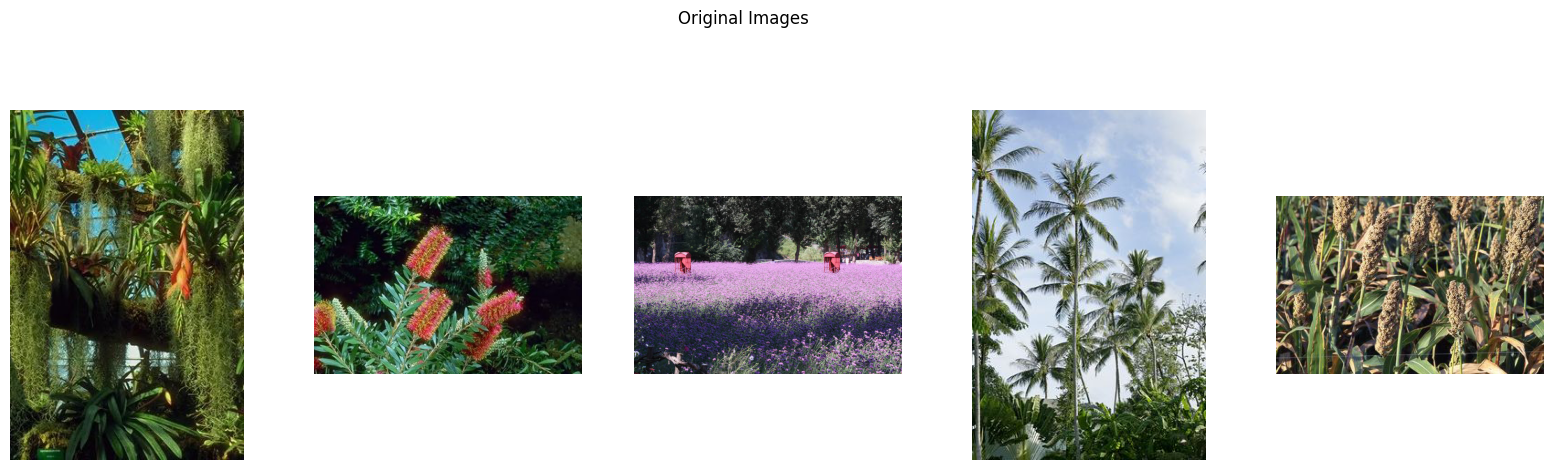

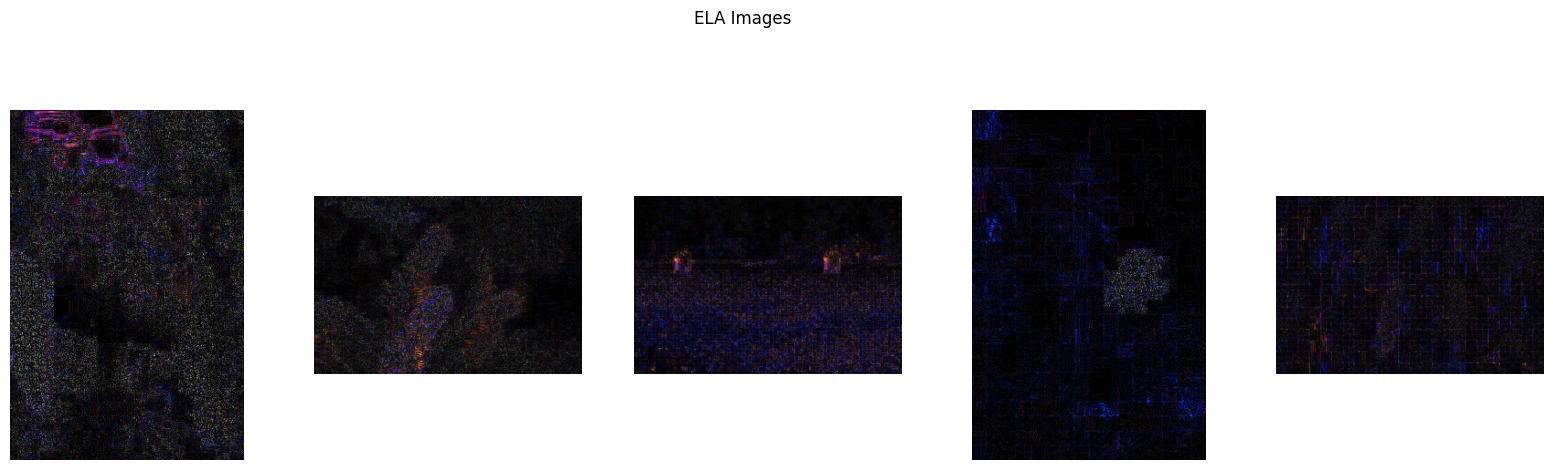

In [ ]:
def display_images(images, title):
    plt.figure(figsize=(20, 10))
    for i in range(len(images)):
        plt.subplot(2, 5, i+1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Display original images
original_images = [Image.open(os.path.join(forged_path, filename)).convert('RGB') for filename in os.listdir(forged_path)[:5]]
display_images(original_images, "Original Images")

# Display ELA images
ela_images = [convert_to_ela_image(os.path.join(forged_path, filename), 90) for filename in os.listdir(forged_path)[:5]]
display_images(ela_images, "ELA Images")

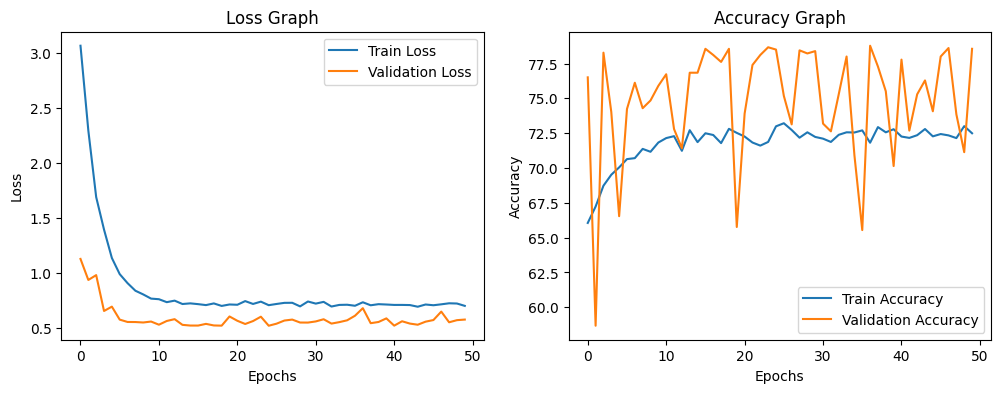

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Graph')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Graph')

plt.show()

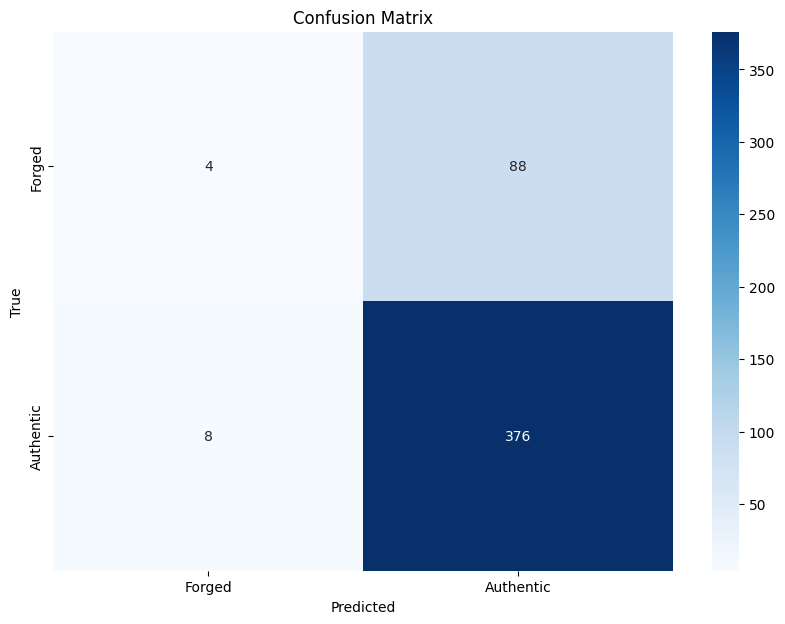

              precision    recall  f1-score   support

      Forged       0.33      0.04      0.08        92
   Authentic       0.81      0.98      0.89       384

    accuracy                           0.80       476
   macro avg       0.57      0.51      0.48       476
weighted avg       0.72      0.80      0.73       476



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Forged', 'Authentic'], yticklabels=['Forged', 'Authentic'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=['Forged', 'Authentic']))

In [ ]:
# List all files in the test directory
test_image_files = os.listdir(test_dir)

# Select the first image file (or any specific image file you want to test)
test_image_path = os.path.join(test_dir, test_image_files[4])

Prediction: Authentic


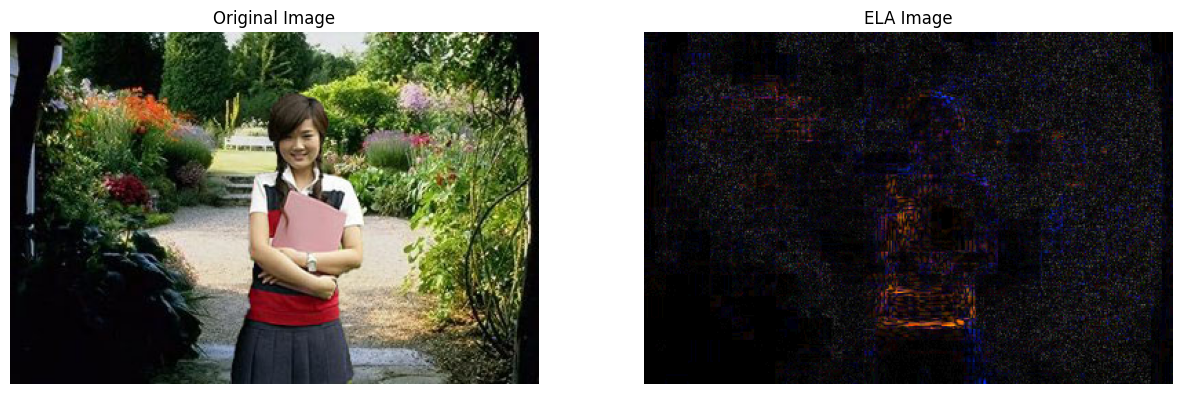

In [ ]:
 # Replace with your test image path
test_image = prepare_image(test_image_path )
test_image = test_image.reshape(-1, 128, 128, 3)
test_image_tensor = torch.tensor(test_image, dtype=torch.float32).permute(0, 3, 1, 2).to(device)

model.eval()
with torch.no_grad():
    y_pred = model(test_image_tensor)
    y_pred_class = torch.argmax(y_pred, dim=1).cpu().numpy()[0]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Display original image
original_image = plt.imread(test_image_path)
ax[0].axis('off')
ax[0].imshow(original_image)
ax[0].set_title('Original Image')

# Display ELA applied image
ax[1].axis('off')
ax[1].imshow(convert_to_ela_image(test_image_path, 90))
ax[1].set_title('ELA Image')

class_names = ['Forged', 'Authentic']
print(f'Prediction: {class_names[y_pred_class]}')

In [ ]:
class_names = ['Forged', 'Authentic']

# Testing accuracy
correct_test = 0  # correctly predicted test images
total_test = 0    # total test images

# Ensure the model is in evaluation mode
model.eval()

# Iterate over the test data
for index, image in enumerate(tqdm(X_test, desc="Processing Images : ")):
    # Reshape the image to match the input shape expected by the model
    image = image.reshape(-1, 128, 128, 3)
    image_tensor = torch.tensor(image, dtype=torch.float32).permute(0, 3, 1, 2).to(device)

    # Make prediction
    with torch.no_grad():
        y_pred = model(image_tensor)
        y_pred_class = torch.argmax(y_pred, dim=1).cpu().numpy()[0]

    # Update total test images count
    total_test += 1

    # Check if the prediction is correct
    if y_pred_class == Y_test[index]:
        correct_test += 1

# Calculate accuracy
accuracy = correct_test / total_test * 100.0
print(f'Total test images: {total_test}\nCorrectly predicted images: {correct_test}\nAccuracy: {accuracy:.2f} %')

Processing Images : 100%|██████████| 476/476 [00:02<00:00, 161.62it/s]

Total test images: 476
Correctly predicted images: 380
Accuracy: 79.83 %


In [ ]:
from PIL import Image

# Initialize counters
authentic, forged, total = 0, 0, 0

# Define the path to the test directory
test_folder_path = '/content/drive/MyDrive/casia/test'

# Function to prepare images
def prepare_image(image_path, target_size=(128, 128)):
    with Image.open(image_path) as img:
        img = img.convert('RGB')  # Ensure 3 color channels
        img = img.resize(target_size)  # Resize image
        return np.array(img)

# Iterate over files in the test directory
for filename in tqdm(os.listdir(test_folder_path), desc="Processing Images : "):
    if filename.endswith('jpg') or filename.endswith('png'):
        test_image_path = os.path.join(test_folder_path, filename)
        test_image = prepare_image(test_image_path)
        test_image = test_image.reshape(-1, 128, 128, 3)
        test_image_tensor = torch.tensor(test_image, dtype=torch.float32).permute(0, 3, 1, 2).to(device)

        # Make prediction
        model.eval()
        with torch.no_grad():
            y_pred = model(test_image_tensor)
            y_pred_class = torch.argmax(y_pred, dim=1).cpu().numpy()[0]

        # Update counters
        total += 1
        if y_pred_class == 0:
            forged += 1
        else:
          authentic += 1

# Print results
print(f'Total images: {total}\nAuthentic Images: {authentic}\nForged Images: {forged}')

Processing Images : 100%|██████████| 476/476 [00:06<00:00, 76.62it/s]

Total images: 476
Authentic Images: 464
Forged Images: 12


In [ ]:
# Initialize counters and lists
authentic, forged, total = 0, 0, 0
forged_indices = []  # Initialize the list to store indices of forged images

# Function to prepare images
def prepare_image(image_path, target_size=(128, 128)):
    with Image.open(image_path) as img:
        img = img.convert('RGB')  # Ensure 3 color channels
        img = img.resize(target_size)  # Resize image
        return np.array(img)

# Iterate over files in the test directory
for index, filename in enumerate(tqdm(os.listdir(test_folder_path), desc="Processing Images : ")):
    if filename.endswith('jpg') or filename.endswith('png'):
        test_image_path = os.path.join(test_folder_path, filename)
        test_image = prepare_image(test_image_path)
        test_image = test_image.reshape(-1, 128, 128, 3)
        test_image_tensor = torch.tensor(test_image, dtype=torch.float32).permute(0, 3, 1, 2).to(device)

        # Make prediction
        model.eval()
        with torch.no_grad():
            y_pred = model(test_image_tensor)
            y_pred_class = torch.argmax(y_pred, dim=1).cpu().numpy()[0]

        # Update counters and store indices
        total += 1
        if y_pred_class == 0:
            forged += 1
            forged_indices.append(index)
        else:
            authentic += 1

# Print results
print(f'Total images: {total}\nAuthentic Images: {authentic}\nForged Images: {forged}')
print(f'Indices of forged images: {forged_indices}')

Processing Images : 100%|██████████| 476/476 [00:05<00:00, 91.46it/s]

Total images: 476
Authentic Images: 464
Forged Images: 12
Indices of forged images: [35, 168, 171, 175, 242, 255, 257, 287, 297, 350, 379, 381]
